In [1]:
# Load swiss temperature data

import pandas as pd
import glob

path = "data/swiss"
filenames = glob.glob(path + "/*.txt")
dfs = []
N = len(filenames)
for filename in filenames:
    with open(filename, encoding="Windows-1252") as f:
        content = f.readlines()
        station = content[5].split(None, 1)[1][:-1]
        altitude = float(content[6].split()[3])
        latitude = int(content[7].split()[1][:-1]) + float(content[7].split()[2][:-1]) / 60
        longitude = int(content[7].split()[5][:-1]) + float(content[7].split()[6][:-1]) / 60
    df = pd.read_table(
        filename,
        encoding="Windows-1252",
        delim_whitespace=True,
        skiprows=27,
    )
    df["Station"] = station
    df["Altitude"] = altitude
    df["Latitude"] = latitude
    df["Longitude"] = longitude
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all.head()


,Year,Month,Temperature,Precipitation,Station,Altitude,Latitude,Longitude
0,1864,1,-4.5,40.8,Altdorf,438.0,46.886667,8.621667
1,1864,2,-0.4,38.0,Altdorf,438.0,46.886667,8.621667
2,1864,3,5.4,31.6,Altdorf,438.0,46.886667,8.621667
3,1864,4,7.2,155.1,Altdorf,438.0,46.886667,8.621667
4,1864,5,12.6,103.9,Altdorf,438.0,46.886667,8.621667


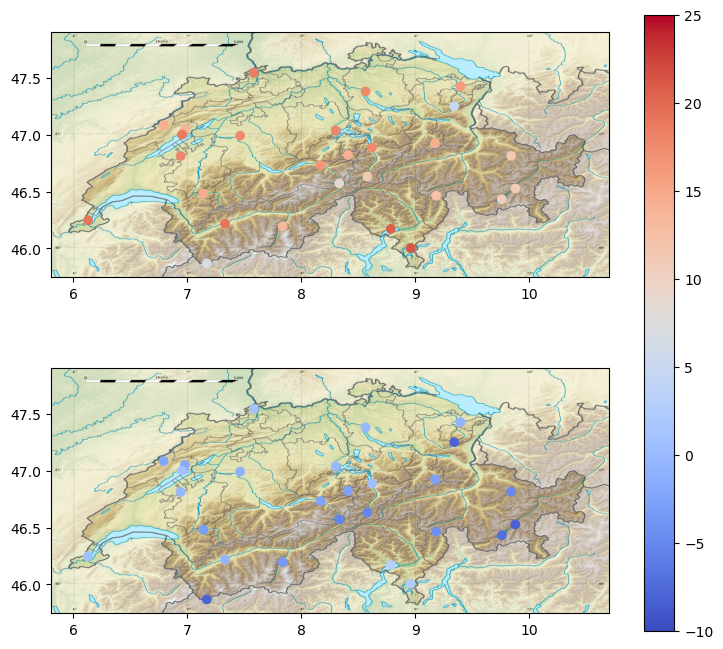

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

data_1965_1989_january = df_all[(df_all["Year"] >= 1965) & (df_all["Year"] < 1990) & (df_all["Month"] == 1)].groupby("Station")
data_1965_1989_july = df_all[(df_all["Year"] >= 1965) & (df_all["Year"] < 1990) & (df_all["Month"] == 7)].groupby("Station")

img = plt.imread("data/swiss/Switzerland_relief_location_map.jpg")
plt.figure(figsize=(9, 8))
ax1 = plt.subplot(2, 1, 1)
ax1.imshow(img, zorder=0, extent=[5.8, 10.7, 45.75, 47.9])
ax1.scatter(data_1965_1989_july.mean()["Longitude"], data_1965_1989_july.mean()["Latitude"], c=data_1965_1989_july.mean()["Temperature"], cmap="coolwarm", vmin=-10, vmax=25)

ax2 = plt.subplot(2, 1, 2)
ax2.imshow(img, zorder=0, extent=[5.8, 10.7, 45.75, 47.9])
im = ax2.scatter(data_1965_1989_january.mean()["Longitude"], data_1965_1989_january.mean()["Latitude"], c=data_1965_1989_january.mean()["Temperature"], cmap="coolwarm", vmin=-10, vmax=25)
plt.colorbar(im, ax=[ax1, ax2])
plt.show()


0
(27, 25)
1
(27, 25)
2
(27, 25)
3
(27, 25)
4
(27, 25)
5
(27, 25)
6
(27, 25)
7
(27, 25)
8
(27, 25)
9
(27, 25)
10
(27, 25)
11
(27, 25)
12
(27, 25)
13
(27, 25)
14
(27, 25)
15
(27, 25)
16
(27, 25)
17
(27, 25)
18
(27, 25)
19
(27, 25)
0
(27, 25)
1
(27, 25)
2
(27, 25)
3
(27, 25)
4
(27, 25)
5
(27, 25)
6
(27, 25)
7
(27, 25)
8
(27, 25)
9
(27, 25)
10
(27, 25)
11
(27, 25)
12
(27, 25)
13
(27, 25)
14
(27, 25)
15
(27, 25)
16
(27, 25)
17
(27, 25)
18
(27, 25)
19
(27, 25)
[[-7.99589061e-08  2.61936970e-09  1.94150705e-09 -1.22149632e-09
  -2.10377147e-10 -2.59616182e-09  1.88154615e-09  2.67651429e-09
  -2.56636008e-10 -3.61395223e-10  1.00960523e-09  1.74047647e-09
  -3.36969319e-09  1.63239020e-10  5.95060402e-10  1.68944464e-09
  -1.16426779e-09  1.04585333e-09  3.30427369e-09 -1.11604133e-09
   2.52230250e-10  6.67736352e-10  1.30313823e-09  1.39402884e-09
   6.94761528e-10  3.72722995e-09 -1.20638192e-09]
 [ 2.61936970e-09 -1.47263114e-07  4.69078414e-09  1.47274404e-09
   2.53616178e-09  7.879437

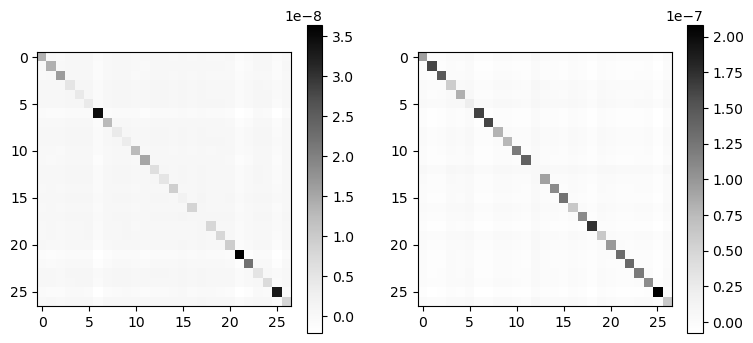

In [56]:
import cvxpy as cp
import numpy as np

def topo_infer_smooth(data, N, alpha, beta, iter):
    M = data.shape[1] if data.ndim == 2 else 1
    if M == 1:
        data = data.reshape(-1, 1)
    y = cp.Variable((N, M))
    y_0 = data
    Lap = cp.Variable((N, N), PSD=True)

    for cnt in range(iter):
        print(cnt)
        constraint = [Lap @ np.ones((N,)) == np.zeros((N,)), Lap - cp.diag(cp.diag(Lap)) <= 0]
        print(y_0.shape)
        objective = cp.Minimize(alpha * cp.trace(cp.quad_form(y_0, Lap)) + beta * cp.norm(Lap, "fro") ** 2)
        prob = cp.Problem(objective, constraint)
        prob.solve()
        Lap_0 = Lap.value
        Lap_0 = Lap_0 - np.eye(N) * np.min(np.linalg.eigvals(Lap_0))
        objective2 = cp.Minimize(cp.norm(y - data, "fro") ** 2 + alpha * cp.sum([cp.quad_form(y[:, i], Lap_0) for i in range(M)]))
        prob2 = cp.Problem(objective2)
        prob2.solve()
        y_0 = y.value
    
    return Lap_0

t_january = np.array(data_1965_1989_january["Temperature"].apply(lambda x: np.array(x.values.tolist())).to_list())
t_july = np.array(data_1965_1989_july["Temperature"].apply(lambda x: np.array(x.values.tolist())).to_list())

alpha = 0.01
beta = 0.5
Lap_0_january = topo_infer_smooth(t_january, N, alpha, beta, 20)
Lap_0_july = topo_infer_smooth(t_july, N, alpha, beta, 20)
print(Lap_0_january - Lap_0_july)

plt.figure(figsize=(9, 4))
plt.subplot(1, 2, 1)
plt.imshow(Lap_0_january, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(Lap_0_july, cmap='Greys', interpolation='nearest')
plt.colorbar()
plt.show()


C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_15616\707182143.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  longitudes = [df_all[df_all.eq(station_name).any(1)]["Longitude"].values[0] for station_name in stations]
C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_15616\707182143.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  latitudes = [df_all[df_all.eq(station_name).any(1)]["Latitude"].values[0] for station_name in stations]
C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_15616\707182143.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  altitudes = np.array([df_all[df_all.eq(station_name).any(1)]["Altitude"].values[0] for station_name in stations])


0
(27, 1)
1
(27, 1)
2
(27, 1)
3
(27, 1)
4
(27, 1)
5
(27, 1)
6
(27, 1)
7
(27, 1)
8
(27, 1)
9
(27, 1)
10
(27, 1)
11
(27, 1)
12
(27, 1)
13
(27, 1)
14
(27, 1)
15
(27, 1)
16
(27, 1)
17
(27, 1)
18
(27, 1)
19
(27, 1)
Altdorf Col du Grand St-Bernard -7.557877880975085e-10
(masked_array(data=[-21.00326048],
             mask=False,
       fill_value=1e+20), True)
Altdorf Samedan -8.302947123241198e-10
(masked_array(data=[-20.9092404],
             mask=False,
       fill_value=1e+20), True)
Altdorf Säntis -7.065189787984193e-10
(masked_array(data=[-21.07067105],
             mask=False,
       fill_value=1e+20), True)
Andermatt Col du Grand St-Bernard -1.0662049305770974e-09
(masked_array(data=[-20.65916029],
             mask=False,
       fill_value=1e+20), True)
Andermatt Samedan -1.1509483208240774e-09
(masked_array(data=[-20.58267961],
             mask=False,
       fill_value=1e+20), True)
Andermatt Segl-Maria -5.470478373675247e-10
(masked_array(data=[-21.32648486],
             mask=Fa

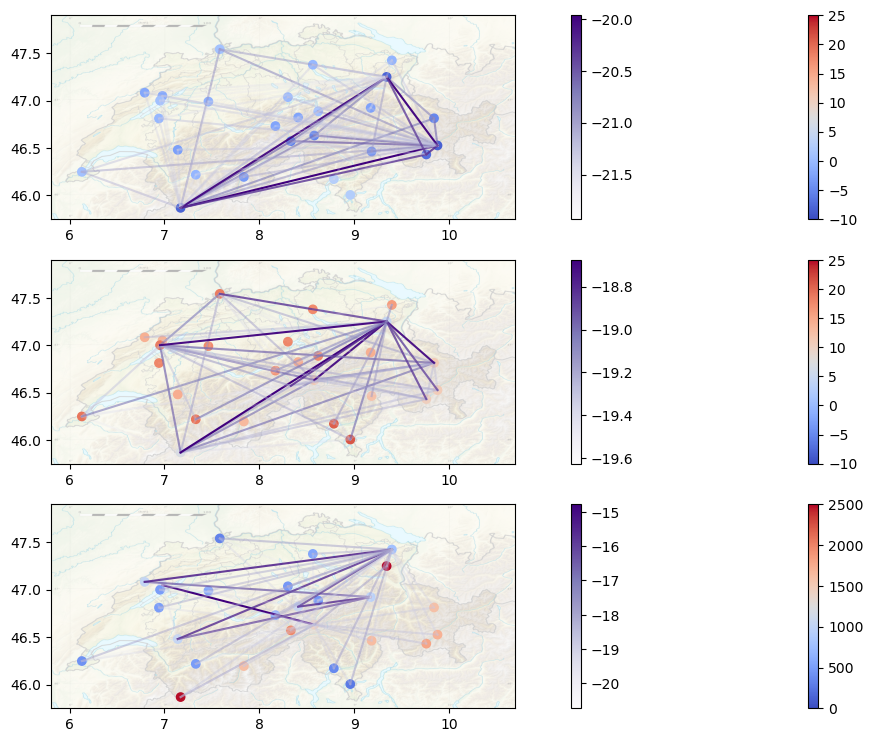

In [76]:
stations = data_1965_1989_january.mean()["Temperature"].keys()
longitudes = [df_all[df_all.eq(station_name).any(1)]["Longitude"].values[0] for station_name in stations]
latitudes = [df_all[df_all.eq(station_name).any(1)]["Latitude"].values[0] for station_name in stations]
altitudes = np.array([df_all[df_all.eq(station_name).any(1)]["Altitude"].values[0] for station_name in stations])

Lap_0_altitude = topo_infer_smooth(altitudes / 200, N, 0.01, 0.3, 20)

def plot_graph(ax, data, Lap, N, th, img, vmin=-10, vmax=25):
    ax.imshow(img, zorder=0, extent=[5.8, 10.7, 45.75, 47.9], alpha=0.3)
    z = ax.scatter(longitudes, latitudes, c=data, cmap="coolwarm", vmin=vmin, vmax=vmax)
    plt.colorbar(z, ax=ax)

    color_norm = mpl.colors.Normalize(vmin=np.log(th), vmax=np.log(np.max(-Lap)))
    cmap = cm.Purples
    color_map = cm.ScalarMappable(norm=color_norm, cmap=cmap)
    for i in range(N):
        for j in range(i+1, N):
            if Lap[i, j] < -th:
                print(stations[i], stations[j], Lap[i, j])
                print(color_norm.process_value(np.log(-Lap[i, j])))
                ax.plot([longitudes[i], longitudes[j]], [latitudes[i], latitudes[j]], c=color_map.to_rgba(np.log(-Lap[i, j])), alpha=color_norm(np.log(-Lap[i, j])))
    plt.colorbar(color_map)

plt.figure(figsize=(18, 9))
ax1 = plt.subplot(3, 1, 1)
plot_graph(ax1, data_1965_1989_january.mean()["Temperature"], Lap_0_january, N, 3e-10, img)

ax2 = plt.subplot(3, 1, 2)
plot_graph(ax2, data_1965_1989_july.mean()["Temperature"], Lap_0_july, N, 3e-9, img)

ax3 = plt.subplot(3, 1, 3)
plot_graph(ax3, altitudes, Lap_0_altitude / 200, N, 1e-9, img, vmin=0, vmax=2500)

plt.show()

In [99]:
print(latitudes)
print(longitudes)
print(stations)

[46.88666666666667, 46.63166666666667, 47.541666666666664, 46.99, 47.05, 46.48, 45.86833333333333, 46.81333333333333, 46.92333333333333, 46.821666666666665, 46.248333333333335, 46.571666666666665, 46.195, 47.083333333333336, 46.17166666666667, 46.005, 47.03666666666667, 46.73166666666667, 47.0, 46.81166666666667, 46.46333333333333, 46.526666666666664, 46.431666666666665, 46.218333333333334, 47.425, 47.25, 47.37833333333333]
[8.621666666666666, 8.58, 7.583333333333333, 7.463333333333333, 6.9783333333333335, 7.14, 7.17, 9.843333333333334, 9.175, 8.41, 6.128333333333333, 8.333333333333334, 7.836666666666667, 6.791666666666667, 8.786666666666667, 8.96, 8.301666666666666, 8.17, 6.953333333333333, 6.941666666666666, 9.185, 9.88, 9.761666666666667, 7.33, 9.398333333333333, 9.343333333333334, 8.565]
Index(['Altdorf', 'Andermatt', 'Basel / Binningen', 'Bern / Zollikofen',
       'Chaumont', 'Château-d'Oex', 'Col du Grand St-Bernard', 'Davos', 'Elm',
       'Engelberg', 'Genève / Cointrin', 'Gri